In [1]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import mne
from mne.preprocessing import ICA
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class EEG_Dataset(Dataset):
    def __init__(
        self,
        index_csv: str,
        base_path: str,
        ch_names: list,
        sfreq: float = 250.0,
        transform: callable = None,  # type: ignore
    ):
        self.base_path = base_path
        self.ch_names = ch_names
        self.sfreq = sfreq
        self.transform = transform

        # Load the index CSV
        self.df = pd.read_csv(os.path.join(base_path, index_csv))
        # the fist half of the dataset
        # If 'label' not in test.csv, self.df['label'] will KeyError; handle below.

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Determine split
        id_num = row["id"]
        if id_num <= 4800:
            split = "train"
        elif id_num <= 4900:
            split = "validation"
        else:
            split = "test"

        # Path to session CSV
        eeg_path = os.path.join(
            self.base_path,
            row["task"],
            split,
            f"{row['subject_id']}",
            str(row["trial_session"]),
            "EEGdata.csv",
        )

        # Load full session
        sess_df = pd.read_csv(eeg_path)

        # Determine samples per trial
        if row["task"] == "MI":
            samp = 9 * self.sfreq  # 2250
        else:  # SSVEP
            samp = 7 * self.sfreq  # 1750

        n = int(samp)
        start = (int(row["trial"]) - 1) * n
        end = start + n

        # Slice out EEG channels only
        data = sess_df[self.ch_names].iloc[start:end].to_numpy().T  # shape (8, n)

        # Optional MNE preprocessing
        info = mne.create_info(
            ch_names=self.ch_names,
            sfreq=self.sfreq,
            ch_types=["eeg"] * len(self.ch_names),  # type: ignore
        )
        if self.transform is not None:
            with mne.utils.use_log_level("WARNING"):
                info = mne.create_info(
                    ch_names=self.ch_names,
                    sfreq=self.sfreq,
                    ch_types=["eeg"] * len(self.ch_names),
                )
                raw = mne.io.RawArray(data, info)
                raw = self.transform(raw)
                data = raw.get_data()

        # To tensor
        eeg_tensor = torch.from_numpy(data).float()

        # Return with/without label
        if "label" in self.df.columns:
            label = row["label"]
            return eeg_tensor, label
        else:
            return eeg_tensor


class MI_Dataset(EEG_Dataset):
    def __init__(
        self,
        base_path: str,
        index_csv: str,
        ch_names: list,
        sfreq: float = 250.0,
        transform: callable = None,  # type: ignore
    ):
        super().__init__(
            base_path=base_path,
            index_csv=index_csv,
            ch_names=ch_names,
            sfreq=sfreq,
            transform=transform,
        )

        self.df = self.df[self.df["task"] == "MI"].reset_index(drop=True)


class SSVEP_Dataset(EEG_Dataset):
    def __init__(
        self,
        base_path: str,
        index_csv: str,
        ch_names: list,
        sfreq: float = 250.0,
        transform: callable = None,  # type: ignore
    ):
        super().__init__(
            base_path=base_path,
            index_csv=index_csv,
            ch_names=ch_names,
            sfreq=sfreq,
            transform=transform,
        )

        self.df = self.df[self.df["task"] == "SSVEP"].reset_index(drop=True)

In [296]:
# ch_names = ["FZ", "C3", "CZ", "C4", "PZ", "PO7", "OZ", "PO8"]
from sklearn.calibration import LabelEncoder


# ch_names = ["OZ", "PO7", "PO8", "PZ"]
CH_NAMES = ["FZ", "C3", "CZ", "C4", "PZ", "PO7", "OZ", "PO8"]
# CH_NAMES = ["PZ", "PO7", "OZ", "PO8", "C3", "C4"]

SFREQ = 250.0

# --- Load Datasets ---
# For simplicity in this example, we won't apply any MNE transforms at the dataset level yet.
train_dataset = SSVEP_Dataset(
    base_path="",
    index_csv="train.csv",
    ch_names=CH_NAMES,
    sfreq=SFREQ,
    transform=lambda raw: raw.notch_filter(
        freqs=50.0, picks="eeg", fir_design="firwin"
    ),
)

validation_dataset = SSVEP_Dataset(
    base_path="",
    index_csv="validation.csv",
    ch_names=CH_NAMES,
    sfreq=SFREQ,
    transform=lambda raw: raw.notch_filter(
        freqs=50.0, picks="eeg", fir_design="firwin"
    ),
)

# --- Create DataLoaders ---
# We can use a batch size of 1 for this kind of feature extraction
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(validation_dataset)}")

# --- Inspect a sample ---
eeg_tensor, label = next(iter(train_loader))
print(f"\nSample EEG tensor shape: {eeg_tensor.shape}")
print(f"Sample label: {label[0]}")

STIM_FREQS = {"Left": 10.0, "Right": 13.0, "Forward": 7.0, "Backward": 8.0}
LABELS = list(STIM_FREQS.keys())

# --- Encode Labels ---
label_encoder = LabelEncoder()
label_encoder.fit(LABELS)
label_encoder.classes_
print(f"Encoded labels: {label_encoder.classes_}")

Number of training samples: 2400
Number of validation samples: 50

Sample EEG tensor shape: torch.Size([1, 8, 1750])
Sample label: Backward
Encoded labels: ['Backward' 'Forward' 'Left' 'Right']


In [297]:
from scipy.signal import butter, sosfilt
from sklearn.cross_decomposition import CCA
import numpy as np

# Use only the most relevant channels for SSVEP
SSVEP_CHANNELS = ["PZ", "PO7", "OZ", "PO8", "C3", "C4"]


def generate_reference_signals(freq, n_samples, sfreq, n_harmonics=2):
    """
    Generates sine and cosine reference signals for a given frequency and its harmonics.
    (This function was correct and remains the same)
    """
    t = np.arange(n_samples) / sfreq
    refs = []
    for h in range(1, n_harmonics + 1):
        refs.append(np.sin(2 * np.pi * h * freq * t))
        refs.append(np.cos(2 * np.pi * h * freq * t))
    return np.stack(refs).T


def create_filter_bank(sfreq, n_bands=5, band_width=8, start_freq=6.0):
    """
    Creates a bank of band-pass Butterworth filters.

    Args:
        sfreq (float): Sampling frequency.
        n_bands (int): The number of filters in the bank.
        band_width (int): The width of each band in Hz.

    Returns:
        list: A list of SOS filter coefficients.
    """
    filters = []
    # Starting frequency for the first band

    for i in range(n_bands):
        low_cut = start_freq + i * band_width
        high_cut = start_freq + (i + 1) * band_width

        # Ensure the high cutoff doesn't exceed the Nyquist frequency
        if high_cut >= sfreq / 2:
            high_cut = sfreq / 2 - 0.1  # Leave a small margin

        sos = butter(5, [low_cut, high_cut], btype="band", fs=sfreq, output="sos")
        filters.append(sos)

        if high_cut >= sfreq / 2 - 0.1:
            break  # Stop if we've reached the Nyquist frequency

    return filters


def correlations_with_fbcca_corrected(
    eeg_tensor,
    all_ch_names,
    stim_freqs,
    sfreq,
    n_harmonics,
    n_bands,
    band_width,
    start_freq,
):
    """
    Classifies a single EEG trial using a CORRECTED Filter Bank CCA (FBCCA).
    """
    # --- 1. Data Selection (Channels and Time) ---
    ssvep_ch_indices = [all_ch_names.index(ch) for ch in SSVEP_CHANNELS]
    # print(f"Selected SSVEP channels indices: {ssvep_ch_indices}")
    eeg_data = eeg_tensor.squeeze(0).numpy()[ssvep_ch_indices, :]

    # Trim the first 0.5s and last 0.5s to focus on the stable part
    trim_samples = int(0.5 * sfreq)
    eeg_data = eeg_data[:, trim_samples:-trim_samples]

    n_samples = eeg_data.shape[1]

    # --- 2. Generate Filter Bank and Reference Signals ---
    n_harmonics = 2
    filter_bank = create_filter_bank(sfreq, n_bands, band_width, start_freq)

    reference_signals = {
        label: generate_reference_signals(freq, n_samples, sfreq, n_harmonics)
        for label, freq in stim_freqs.items()
    }

    # --- 3. Apply FBCCA ---
    cca = CCA(n_components=1)
    class_scores = {}

    for label, ref_sig in reference_signals.items():
        correlations = []

        # Iterate through each filter in the bank
        for sos_filter in filter_bank:
            # Filter the EEG data for the current sub-band
            eeg_filtered = sosfilt(sos_filter, eeg_data, axis=1)

            # CCA between filtered EEG and the reference signal
            cca.fit(eeg_filtered.T, ref_sig)
            u, v = cca.transform(eeg_filtered.T, ref_sig)
            corr = np.corrcoef(u.T, v.T)[0, 1]
            correlations.append(corr)

        # Combine the correlations. Using simple sum of squares is a robust start.
        # class_scores[label] = np.max(np.array(correlations))
        class_scores[label] = correlations
        # normalize the scores
        # class_scores[label] = class_scores[label] / np.linalg.norm(class_scores[label])
        
        # softmax
        # class_scores[label] = np
        # class_scores[label] = correlations

    # The predicted class is the one with the highest combined score
    return class_scores

In [298]:
eeg_tensor, label = train_dataset[1]
print(f"Sample EEG tensor shape: {eeg_tensor.shape}")
print(f"Sample label: {label}, frequency: {STIM_FREQS[label]} Hz")

Sample EEG tensor shape: torch.Size([8, 1750])
Sample label: Left, frequency: 10.0 Hz


In [299]:
def extract_fbcca_features(
    eeg_tensor,
    all_ch_names,
    stim_freqs,
    sfreq,
    n_harmonics=2,
    n_bands=5,
    band_width=8,
    start_freq=6.0,
):
    """
    Calculates FBCCA scores for a single EEG trial and returns them as a feature vector.
    This function is essentially your `correlations_with_fbcca_corrected` but returns the raw scores.
    """
    class_scores = correlations_with_fbcca_corrected(
        eeg_tensor,
        all_ch_names,
        stim_freqs,
        sfreq,
        n_harmonics,
        n_bands,
        band_width,
        start_freq,
    )

    # Return the scores in a consistent order
    feature_vector = [class_scores[label] for label in sorted(stim_freqs.keys())]
    return np.array(feature_vector)

In [300]:
# sample 
feature_vector = extract_fbcca_features(
    eeg_tensor, CH_NAMES, STIM_FREQS, SFREQ
)
print(f"Feature vector shape: {feature_vector.shape}")
print(f"Feature vector ({type(feature_vector)}): {feature_vector}")


Feature vector shape: (4, 5)
Feature vector (<class 'numpy.ndarray'>): [[0.35357532 0.25495393 0.00505626 0.0051185  0.00333924]
 [0.42342641 0.24660115 0.00400836 0.00484216 0.0032825 ]
 [0.2807396  0.24993611 0.03366242 0.00587739 0.00348929]
 [0.1932844  0.10401011 0.29226594 0.01523484 0.00379128]]


In [302]:
X_train = []
y_train = []
for i in tqdm(range(len(train_dataset))):
    eeg_tensor, label = train_dataset[i]
    class_scores = extract_fbcca_features(
        eeg_tensor,
        CH_NAMES,
        STIM_FREQS,
        SFREQ,
        n_harmonics=2,
        n_bands=5,
        band_width=8,
        start_freq=6.0,
    )
    X_train.append(class_scores.flatten())
    y_train.append(label_encoder.transform([label])[0])  # type: ignore # Encode label

X_train = np.array(X_train)
y_train = np.array(y_train)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

100%|██████████| 2400/2400 [04:49<00:00,  8.29it/s]

X_train shape: (2400, 20), y_train shape: (2400,)


In [280]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

X_train shape: (2400, 20), y_train shape: (2400,)


In [303]:
X_validation = []
y_validation = []
for i in tqdm(range(len(validation_dataset))):
    eeg_tensor, label = validation_dataset[i]
    # Extract FBCCA features
    class_scores = extract_fbcca_features(
        eeg_tensor,
        CH_NAMES,
        STIM_FREQS,
        SFREQ,
        n_harmonics=2,
        n_bands=5,
        band_width=8,
        start_freq=6.0,
    )
    X_validation.append(class_scores.flatten())
    y_validation.append(label_encoder.transform([label])[0])  # type: ignore # Encode label
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)
print(
    f"X_validation shape: {X_validation.shape}, y_validation shape: {y_validation.shape}"
)

  2%|▏         | 1/50 [00:00<00:07,  6.19it/s]

100%|██████████| 50/50 [00:06<00:00,  7.34it/s]

X_validation shape: (50, 20), y_validation shape: (50,)


In [281]:
# SVM
from sklearn.svm import SVC

# Train a simple SVM classifier
svm_classifier = SVC(kernel="linear", probability=True)
svm_classifier.fit(X_train, y_train)
# Evaluate on validation set
train_accuracy = svm_classifier.score(X_train, y_train)
validation_accuracy = svm_classifier.score(X_validation, y_validation)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {validation_accuracy:.4f}")

Training accuracy: 0.6663
Validation accuracy: 0.4600


In [100]:
# KNN 
from sklearn.neighbors import KNeighborsClassifier
# Train a KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
knn_classifier.fit(X_train, y_train)
# Evaluate on validation set
train_accuracy_knn = knn_classifier.score(X_train, y_train)
validation_accuracy_knn = knn_classifier.score(X_validation, y_validation)
print(f"KNN Training accuracy: {train_accuracy_knn:.4f}")
print(f"KNN Validation accuracy: {validation_accuracy_knn:.4f}")

KNN Training accuracy: 0.6958
KNN Validation accuracy: 0.5200


In [101]:
for i in range(1, 15, 2):
    knn_classifier = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    knn_classifier.fit(X_train, y_train)
    train_accuracy_knn = knn_classifier.score(X_train, y_train)
    validation_accuracy_knn = knn_classifier.score(X_validation, y_validation)
    print(f"KNN (k={i}): {train_accuracy_knn:.4f}  |  {validation_accuracy_knn:.4f}")

KNN (k=1): 1.0000  |  0.4000
KNN (k=3): 0.7471  |  0.4400
KNN (k=5): 0.7267  |  0.4800
KNN (k=7): 0.7050  |  0.4200
KNN (k=9): 0.6958  |  0.5200
KNN (k=11): 0.6875  |  0.4600
KNN (k=13): 0.6892  |  0.4800


In [104]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42, max_depth=9)
rf_classifier.fit(X_train, y_train)
# Evaluate on validation set
train_accuracy_rf = rf_classifier.score(X_train, y_train)
validation_accuracy_rf = rf_classifier.score(X_validation, y_validation)
print(f"Random Forest Training accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Validation accuracy: {validation_accuracy_rf:.4f}")

Random Forest Training accuracy: 0.8467
Random Forest Validation accuracy: 0.5200


In [282]:
for i in range(3, 10):
    rf_classifier = RandomForestClassifier(
        n_estimators=170, n_jobs=-1, random_state=42, max_depth=i
    )
    rf_classifier.fit(X_train, y_train)
    train_accuracy_rf = rf_classifier.score(X_train, y_train)
    validation_accuracy_rf = rf_classifier.score(X_validation, y_validation)
    print(
        f"Random Forest (max_depth={i}): {train_accuracy_rf:.4f}  |  {validation_accuracy_rf:.4f}"
    )

Random Forest (max_depth=3): 0.6400  |  0.4200
Random Forest (max_depth=4): 0.6592  |  0.4400
Random Forest (max_depth=5): 0.6800  |  0.4600
Random Forest (max_depth=6): 0.7092  |  0.4800
Random Forest (max_depth=7): 0.7483  |  0.5200
Random Forest (max_depth=8): 0.7883  |  0.5000
Random Forest (max_depth=9): 0.8504  |  0.5200


In [105]:
# XGBoost
from xgboost import XGBClassifier

# Train an XGBoost classifier
xgb_classifier = XGBClassifier(
    use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1, random_state=42,
    n_estimators=20, max_depth=7, learning_rate=0.1, subsample=0.4, colsample_bytree=0.8
)
xgb_classifier.fit(X_train, y_train)
# Evaluate on validation set
train_accuracy_xgb = xgb_classifier.score(X_train, y_train)
validation_accuracy_xgb = xgb_classifier.score(X_validation, y_validation)
print(f"XGBoost Training accuracy: {train_accuracy_xgb:.4f}")
print(f"XGBoost Validation accuracy: {validation_accuracy_xgb:.4f}")

XGBoost Training accuracy: 0.8304
XGBoost Validation accuracy: 0.4400


In [ ]:
best = None
for i in range(10, 210, 10):
    for j in range(4, 10):
        rf_classifier = RandomForestClassifier(
            n_estimators=i, n_jobs=-1, random_state=42, max_depth=j
        )
        rf_classifier.fit(X_train, y_train)
        train_accuracy_rf = rf_classifier.score(X_train, y_train)
        validation_accuracy_rf = rf_classifier.score(X_validation, y_validation)
        print(
            f"Random Forest (n_estimators={i}, max_depth={j}): {train_accuracy_rf:.4f}  |  {validation_accuracy_rf:.4f}",
            "Best so far: ",
            best[-1] if best else "None",
        )
        if best is None or validation_accuracy_rf > best[-1]:
            best = (rf_classifier, train_accuracy_rf, validation_accuracy_rf)


Random Forest (n_estimators=10, max_depth=4): 0.6450  |  0.4600 Best so far:  None
Random Forest (n_estimators=10, max_depth=5): 0.6663  |  0.4600 Best so far:  0.46
Random Forest (n_estimators=10, max_depth=6): 0.7000  |  0.4800 Best so far:  0.46
Random Forest (n_estimators=10, max_depth=7): 0.7362  |  0.4800 Best so far:  0.48
Random Forest (n_estimators=10, max_depth=8): 0.7667  |  0.4200 Best so far:  0.48
Random Forest (n_estimators=10, max_depth=9): 0.8050  |  0.4600 Best so far:  0.48
Random Forest (n_estimators=20, max_depth=4): 0.6575  |  0.4600 Best so far:  0.48
Random Forest (n_estimators=20, max_depth=5): 0.6742  |  0.4600 Best so far:  0.48
Random Forest (n_estimators=20, max_depth=6): 0.7113  |  0.4800 Best so far:  0.48
Random Forest (n_estimators=20, max_depth=7): 0.7454  |  0.4400 Best so far:  0.48
Random Forest (n_estimators=20, max_depth=8): 0.7908  |  0.5000 Best so far:  0.48
Random Forest (n_estimators=20, max_depth=9): 0.8163  |  0.4600 Best so far:  0.5
Rando

In [106]:
print(f"Best Random Forest model: {best[0]}")
print(f"Best Training accuracy: {best[1]:.4f}")
print(f"Best Validation accuracy: {best[2]:.4f}")

NameError: name 'best' is not defined

In [30]:
# lazy classifier
from lazypredict.Supervised import LazyClassifier, LazyRegressor

lazy_classifier = LazyClassifier(
    ignore_warnings=True,
    custom_metric=None,
    random_state=42,
)

# Fit the lazy classifier
models, predictions = lazy_classifier.fit(X_train, X_validation, y_train, y_validation)
# Display the results
print(models)

 97%|█████████▋| 30/31 [00:04<00:00,  6.46it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 20
[LightGBM] [Info] Start training from score -1.328025
[LightGBM] [Info] Start training from score -1.420196
[LightGBM] [Info] Start training from score -1.411612
[LightGBM] [Info] Start training from score -1.387962


100%|██████████| 31/31 [00:04<00:00,  6.66it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
AdaBoostClassifier                 0.50               0.51    None      0.49   
BernoulliNB                        0.50               0.50    None      0.49   
RandomForestClassifier             0.46               0.47    None      0.46   
XGBClassifier                      0.46               0.46    None      0.47   
NearestCentroid                    0.46               0.45    None      0.45   
LGBMClassifier                     0.44               0.45    None      0.43   
LogisticRegression                 0.44               0.43    None      0.44   
RidgeClassifierCV                  0.44               0.43    None      0.42   
RidgeClassifier                    0.44               0.43    None      0.42   
DecisionTreeClassifier             0.42               0.43    None      0.42   
ExtraTreesClassifier               0.42 

In [107]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier
# Train an AdaBoost classifier
ada_classifier = AdaBoostClassifier(
    n_estimators=60, random_state=42, learning_rate=0.1
)
ada_classifier.fit(X_train, y_train)
# Evaluate on validation set
train_accuracy_ada = ada_classifier.score(X_train, y_train)
validation_accuracy_ada = ada_classifier.score(X_validation, y_validation)
print(f"AdaBoost Training accuracy: {train_accuracy_ada:.4f}")
print(f"AdaBoost Validation accuracy: {validation_accuracy_ada:.4f}")

AdaBoost Training accuracy: 0.6592
AdaBoost Validation accuracy: 0.4400


In [108]:
# ridge
from sklearn.linear_model import RidgeClassifier
# Train a Ridge Classifier
ridge_classifier = RidgeClassifier(alpha=1.0, random_state=42)
ridge_classifier.fit(X_train, y_train)
# Evaluate on validation set
train_accuracy_ridge = ridge_classifier.score(X_train, y_train)
validation_accuracy_ridge = ridge_classifier.score(X_validation, y_validation)
print(f"Ridge Classifier Training accuracy: {train_accuracy_ridge:.4f}")
print(f"Ridge Classifier Validation accuracy: {validation_accuracy_ridge:.4f}")

Ridge Classifier Training accuracy: 0.6675
Ridge Classifier Validation accuracy: 0.4800


In [164]:
raw = mne.io.RawArray(
    eeg_tensor[0].numpy(),
    mne.create_info(ch_names=CH_NAMES, sfreq=SFREQ, ch_types=["eeg"] * len(CH_NAMES)),
)

Creating RawArray with float64 data, n_channels=8, n_times=1750
    Range : 0 ... 1749 =      0.000 ...     6.996 secs
Ready.


Effective window size : 7.000 (s)
Plotting power spectral density (dB=True).


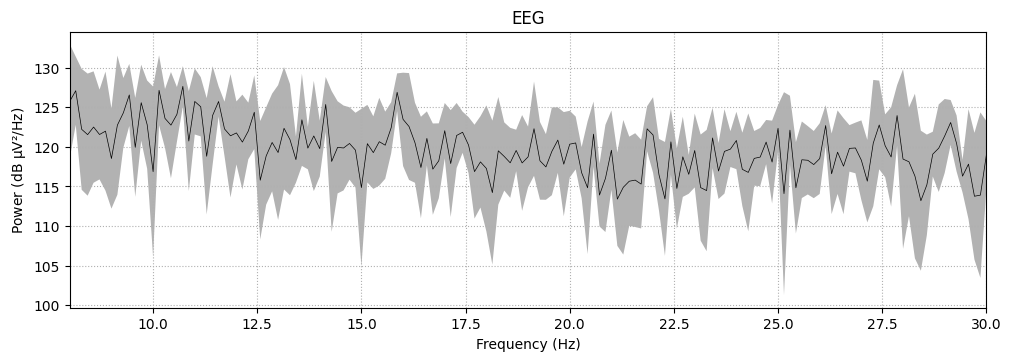

In [246]:
fig = raw.compute_psd(tmax=np.inf, fmin=8, fmax=30).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)

In [165]:
N_HARMONICS = 2 # Let's use the fundamental and the first harmonic

# Create a flat list of all frequencies of interest
freqs_of_interest = []
for freq in STIM_FREQS.values():
    for i in range(1, N_HARMONICS + 1):
        freqs_of_interest.append(freq * i)

freqs_of_interest

[10.0, 20.0, 13.0, 26.0, 7.0, 14.0, 8.0, 16.0]

In [167]:
psds, freqs = raw.compute_psd(
    method='welch', 
    fmin=1.0, 
    fmax=60, # Make sure fmax covers your highest harmonic
    n_fft=1024 # Use a larger n_fft for better frequency resolution
).get_data(return_freqs=True)

Effective window size : 4.096 (s)


In [169]:
n_features = len(freqs_of_interest) * 8
n_features

64

In [304]:
X_tr = []
y_tr = []
with mne.utils.use_log_level("WARNING"):
    for i in tqdm(range(len(train_dataset))):
        eeg_tensor, label = train_dataset[i]
        raw = mne.io.RawArray(
            eeg_tensor.numpy(),
            mne.create_info(
                ch_names=CH_NAMES, sfreq=SFREQ, ch_types=["eeg"] * len(CH_NAMES)
            ),
        )
        # Compute the PSD for the current EEG trial
        psds, freqs = raw.compute_psd(
            method="welch",
            fmin=1.0,
            fmax=60,  # Ensure this covers your highest harmonic
            n_fft=1024,  # Use a larger n_fft for better frequency resolution
        ).get_data(return_freqs=True)

        feature_vector = []
        for freq in freqs_of_interest:
            # Find the index of the closest frequency in the PSD
            idx = np.argmin(np.abs(freqs - freq))
            # Extract the power spectral density value for that frequency
            psd_value = psds[:, idx]
            feature_vector.extend(psd_value)
        # Append the feature vector and label
        X_tr.append(feature_vector)
        y_tr.append(label_encoder.transform([label])[0])  # type:

100%|██████████| 2400/2400 [03:04<00:00, 13.03it/s]


In [305]:
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

In [306]:
print(f"X_tr shape: {X_tr.shape}, y_tr shape: {y_tr.shape}")

X_tr shape: (2400, 64), y_tr shape: (2400,)


In [307]:
X_dev = []
y_dev = []

with mne.utils.use_log_level("WARNING"):
    for i in tqdm(range(len(validation_dataset))):
        eeg_tensor, label = validation_dataset[i]
        raw = mne.io.RawArray(
            eeg_tensor.numpy(),
            mne.create_info(
                ch_names=CH_NAMES, sfreq=SFREQ, ch_types=["eeg"] * len(CH_NAMES)
            ),
        )
        # Compute the PSD for the current EEG trial
        psds, freqs = raw.compute_psd(
            method="welch",
            fmin=1.0,
            fmax=60,  # Ensure this covers your highest harmonic
            n_fft=1024,  # Use a larger n_fft for better frequency resolution
        ).get_data(return_freqs=True)

        feature_vector = []
        for freq in freqs_of_interest:
            # Find the index of the closest frequency in the PSD
            idx = np.argmin(np.abs(freqs - freq))
            # Extract the power spectral density value for that frequency
            psd_value = psds[:, idx]
            feature_vector.extend(psd_value)
        # Append the feature vector and label
        X_dev.append(feature_vector)
        y_dev.append(label_encoder.transform([label])[0])  # type: ignore

X_dev = np.array(X_dev)
y_dev = np.array(y_dev)
print(f"X_dev shape: {X_dev.shape}, y_dev shape: {y_dev.shape}")

100%|██████████| 50/50 [00:03<00:00, 14.27it/s]

X_dev shape: (50, 64), y_dev shape: (50,)


In [308]:
# KNN
knn_classifier = KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
knn_classifier.fit(X_tr, y_tr)
# Evaluate on validation set
train_accuracy_knn = knn_classifier.score(X_tr, y_tr)
validation_accuracy_knn = knn_classifier.score(X_dev, y_dev)
print(f"KNN Training accuracy: {train_accuracy_knn:.4f}")
print(f"KNN Validation accuracy: {validation_accuracy_knn:.4f}")


KNN Training accuracy: 0.4404
KNN Validation accuracy: 0.2200


In [309]:
for k in range(1, 15, 2):
    knn_classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_classifier.fit(X_tr, y_tr)
    train_accuracy_knn = knn_classifier.score(X_tr, y_tr)
    validation_accuracy_knn = knn_classifier.score(X_dev, y_dev)
    print(f"KNN (k={k}): {train_accuracy_knn:.4f}  |  {validation_accuracy_knn:.4f}")

KNN (k=1): 1.0000  |  0.3000
KNN (k=3): 0.5621  |  0.2200
KNN (k=5): 0.5042  |  0.2400
KNN (k=7): 0.4725  |  0.3200
KNN (k=9): 0.4404  |  0.2200
KNN (k=11): 0.4192  |  0.0600
KNN (k=13): 0.4138  |  0.2800


In [310]:
# random forest
rf_classifier = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42, max_depth=9)
rf_classifier.fit(X_tr, y_tr)
# Evaluate on validation set
train_accuracy_rf = rf_classifier.score(X_tr, y_tr)
validation_accuracy_rf = rf_classifier.score(X_dev, y_dev)
print(f"Random Forest Training accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Validation accuracy: {validation_accuracy_rf:.4f}")

Random Forest Training accuracy: 0.9883
Random Forest Validation accuracy: 0.2400


In [311]:
grid = [(i, j) for i in range(3, 10) for j in range(10, 200, 10)]
best = [0, 0, 0, 0]
for i, j in grid:
    rf_classifier = RandomForestClassifier(
        n_estimators=j, n_jobs=-1, random_state=42, max_depth=i
    )
    rf_classifier.fit(X_tr, y_tr)
    train_accuracy_rf = rf_classifier.score(X_tr, y_tr)
    validation_accuracy_rf = rf_classifier.score(X_dev, y_dev)
    if best is None or validation_accuracy_rf > best[-1]:
        best = (rf_classifier, train_accuracy_rf, validation_accuracy_rf)
        print(f"Found better model: {best[0]} | {best[1]:.4f} | {best[2]:.4f}")

Found better model: RandomForestClassifier(max_depth=3, n_estimators=10, n_jobs=-1, random_state=42) | 0.3592 | 0.3000
Found better model: RandomForestClassifier(max_depth=4, n_estimators=40, n_jobs=-1, random_state=42) | 0.4925 | 0.3200


KeyboardInterrupt: 

In [318]:
(y_tr != y_train).sum(), (y_dev != y_validation).sum()

(0, 0)

In [319]:
X_train_big = np.concatenate((X_tr, X_train), axis=1)
X_validation_big = np.concatenate((X_dev, X_validation), axis=1)
# Combine labels

X_train_big.shape, X_validation_big.shape, y_train.shape, y_validation.shape

((2400, 84), (50, 84), (2400,), (50,))

In [320]:
# KNN
for k in range(1, 15, 2):
    knn_classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_classifier.fit(X_train_big, y_train)
    train_accuracy_knn = knn_classifier.score(X_train_big, y_train)
    validation_accuracy_knn = knn_classifier.score(X_validation_big, y_validation)
    print(f"KNN (k={k}): {train_accuracy_knn:.4f}  |  {validation_accuracy_knn:.4f}")

KNN (k=1): 1.0000  |  0.3000
KNN (k=3): 0.5625  |  0.2200
KNN (k=5): 0.5046  |  0.2400
KNN (k=7): 0.4725  |  0.3200
KNN (k=9): 0.4408  |  0.2200
KNN (k=11): 0.4192  |  0.0600
KNN (k=13): 0.4146  |  0.2800


In [321]:
# RIDGE
ridge_classifier = RidgeClassifier(alpha=1.0, random_state=42)
ridge_classifier.fit(X_train_big, y_train)
# Evaluate on validation set
train_accuracy_ridge = ridge_classifier.score(X_train_big, y_train)
validation_accuracy_ridge = ridge_classifier.score(X_validation_big, y_validation)
print(f"Ridge Classifier Training accuracy: {train_accuracy_ridge:.4f}")
print(f"Ridge Classifier Validation accuracy: {validation_accuracy_ridge:.4f}")

Ridge Classifier Training accuracy: 0.6975
Ridge Classifier Validation accuracy: 0.4200


In [322]:
# hyperparameter tuning for ridge
grid = [(i / 15.0) for i in range(1, 40)]
best = [0, 0, 0, 0]
for i in grid:
    ridge_classifier = RidgeClassifier(alpha=i, random_state=42)
    ridge_classifier.fit(X_train_big, y_train)
    train_accuracy_ridge = ridge_classifier.score(X_train_big, y_train)
    validation_accuracy_ridge = ridge_classifier.score(X_validation_big, y_validation)
    if best is None or validation_accuracy_ridge > best[-1]:
        best = (ridge_classifier, train_accuracy_ridge, validation_accuracy_ridge)
        print(f"Found better model: {best[0]} | {best[1]:.4f} | {best[2]:.4f}")

Found better model: RidgeClassifier(alpha=0.06666666666666667, random_state=42) | 0.6958 | 0.4200
Found better model: RidgeClassifier(alpha=0.3333333333333333, random_state=42) | 0.6975 | 0.4400


In [323]:
# Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=150, n_jobs=-1, random_state=42, max_depth=9
)
rf_classifier.fit(X_train_big, y_train)
# Evaluate on validation set
train_accuracy_rf = rf_classifier.score(X_train_big, y_train)
validation_accuracy_rf = rf_classifier.score(X_validation_big, y_validation)
print(f"Random Forest Training accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Validation accuracy: {validation_accuracy_rf:.4f}")

Random Forest Training accuracy: 0.9287
Random Forest Validation accuracy: 0.4400


In [324]:
grid = [(n, d) for n in range(10, 210, 10) for d in range(3, 10)]
best = [0]
for n, d in tqdm(grid):
    rf_classifier = RandomForestClassifier(
        n_estimators=n, n_jobs=-1, random_state=42, max_depth=d
    )
    rf_classifier.fit(X_train_big, y_train)
    train_accuracy_rf = rf_classifier.score(X_train_big, y_train)
    validation_accuracy_rf = rf_classifier.score(X_validation_big, y_validation)
    if best is None or validation_accuracy_rf > best[-1]:
        best = (rf_classifier, train_accuracy_rf, validation_accuracy_rf)
        print(f"Found better model: {best[0]} | {best[1]:.4f} | {best[2]:.4f}")

  1%|          | 1/140 [00:00<00:16,  8.64it/s]

Found better model: RandomForestClassifier(max_depth=3, n_estimators=10, n_jobs=-1, random_state=42) | 0.6383 | 0.4600
Found better model: RandomForestClassifier(max_depth=4, n_estimators=10, n_jobs=-1, random_state=42) | 0.6658 | 0.5000


  7%|▋         | 10/140 [00:01<00:14,  9.11it/s]

Found better model: RandomForestClassifier(max_depth=4, n_estimators=20, n_jobs=-1, random_state=42) | 0.6854 | 0.5400


 73%|███████▎  | 102/140 [00:26<00:15,  2.38it/s]

Found better model: RandomForestClassifier(max_depth=6, n_estimators=150, n_jobs=-1,
                       random_state=42) | 0.7683 | 0.5600


100%|██████████| 140/140 [00:46<00:00,  3.03it/s]


In [325]:
random_forest_best = best[0]
print(f"Best Random Forest model: {random_forest_best}")
print(f"Best Training accuracy: {best[1]:.4f}")
print(f"Best Validation accuracy: {best[2]:.4f}")

Best Random Forest model: RandomForestClassifier(max_depth=6, n_estimators=150, n_jobs=-1,
                       random_state=42)
Best Training accuracy: 0.7683
Best Validation accuracy: 0.5600


In [326]:
model = RandomForestClassifier(max_depth=6, n_estimators=150, n_jobs=-1, random_state=42)
model.fit(X_train_big, y_train)
train_accuracy = model.score(X_train_big, y_train)
validation_accuracy = model.score(X_validation_big, y_validation)
print(f"Final Training accuracy: {train_accuracy:.4f}")
print(f"Final Validation accuracy: {validation_accuracy:.4f}")

Final Training accuracy: 0.7683
Final Validation accuracy: 0.5600


In [327]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_validation_big)
print(classification_report(y_validation, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

    Backward       0.60      0.64      0.62        14
     Forward       0.62      0.67      0.64        12
        Left       0.45      0.36      0.40        14
       Right       0.55      0.60      0.57        10

    accuracy                           0.56        50
   macro avg       0.55      0.57      0.56        50
weighted avg       0.55      0.56      0.55        50



In [249]:
# save the model
import joblib
joblib.dump(model, "ssvep_random_forest_model_56acc_56f1.pkl")

['ssvep_random_forest_model_56acc_56f1.pkl']

In [329]:
# load test dataset
test_dataset = SSVEP_Dataset(
    base_path="",
    index_csv="test.csv",
    ch_names=CH_NAMES,
    sfreq=SFREQ,
    transform=lambda raw: raw.notch_filter(
        freqs=50.0, picks="eeg", fir_design="firwin"
    ),
)
# Extract features from the test dataset
X_test = []
with mne.utils.use_log_level("WARNING"):
    for i in tqdm(range(len(test_dataset))):
        eeg_tensor = test_dataset[i]
        raw = mne.io.RawArray(
            eeg_tensor.numpy(),
            mne.create_info(
                ch_names=CH_NAMES, sfreq=SFREQ, ch_types=["eeg"] * len(CH_NAMES)
            ),
        )
        # Compute the PSD for the current EEG trial
        psds, freqs = raw.compute_psd(
            method="welch",
            fmin=1.0,
            fmax=60,  # Ensure this covers your highest harmonic
            n_fft=1024,  # Use a larger n_fft for better frequency resolution
        ).get_data(return_freqs=True)

        feature_vector = []
        for freq in freqs_of_interest:
            # Find the index of the closest frequency in the PSD
            idx = np.argmin(np.abs(freqs - freq))
            # Extract the power spectral density value for that frequency
            psd_value = psds[:, idx]
            feature_vector.extend(psd_value)
        psd_vector = np.array(feature_vector)
        
        class_scores = extract_fbcca_features(
            eeg_tensor,
            CH_NAMES,
            STIM_FREQS,
            SFREQ,
            n_harmonics=2,
            n_bands=5,
            band_width=8,
            start_freq=6.0,
        )
        X_test.append(np.concatenate((psd_vector, class_scores.flatten())))
        
X_test = np.array(X_test)
print(f"X_test shape: {X_test.shape}")

100%|██████████| 50/50 [00:05<00:00,  8.81it/s]

X_test shape: (50, 84)


In [330]:
# predict on the test set
y_test_pred = model.predict(X_test)
# Inverse transform the labels to get the original class names
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)
# Save the predictions to a CSV file
test_df = pd.DataFrame({"id": test_dataset.df["id"], "label": y_test_pred_labels})
test_df.to_csv("ssvep_RF_56_predictions.csv", index=False)
# Save the predictions to a CSV file
print("Test predictions saved to ssvep_RF_56_predictions.csv")

Test predictions saved to ssvep_RF_56_predictions.csv


In [245]:
# f1
from sklearn.metrics import f1_score

f1 = f1_score(y_validation, y_pred, average="weighted")
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.5537


In [208]:
# XGBoost
from xgboost import XGBClassifier

# Train an XGBoost classifier
xgb_classifier = XGBClassifier(
    use_label_encoder=False,
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42,
    n_estimators=20,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.4,
    colsample_bytree=0.8,
)
xgb_classifier.fit(X_train_big, y_train)
# Evaluate on validation set
train_accuracy_xgb = xgb_classifier.score(X_train_big, y_train)
validation_accuracy_xgb = xgb_classifier.score(X_validation_big, y_validation)
print(f"XGBoost Training accuracy: {train_accuracy_xgb:.4f}")
print(f"XGBoost Validation accuracy: {validation_accuracy_xgb:.4f}")

XGBoost Training accuracy: 0.8883
XGBoost Validation accuracy: 0.5200


In [212]:
grid = [(n, d) for n in range(10, 210, 10) for d in range(3, 10)]
best = [0]
for n, d in tqdm(grid):
    xgb_classifier = XGBClassifier(
        use_label_encoder=False,
        eval_metric="mlogloss",
        n_jobs=-1,
        random_state=42,
        n_estimators=n,
        max_depth=d,
        learning_rate=0.1,
        subsample=0.4,
        colsample_bytree=0.8,
    )
    xgb_classifier.fit(X_train_big, y_train)
    train_accuracy_xgb = xgb_classifier.score(X_train_big, y_train)
    validation_accuracy_xgb = xgb_classifier.score(X_validation_big, y_validation)
    if best is None or validation_accuracy_xgb > best[-1]:
        best = (xgb_classifier, train_accuracy_xgb, validation_accuracy_xgb)
        print(
            f"Found better model: (num_estimators={n}, max_depth={d}) | {best[1]:.4f} | {best[2]:.4f}"
        )

  1%|▏         | 2/140 [00:00<00:31,  4.39it/s]

Found better model: (num_estimators=10, max_depth=3) | 0.6758 | 0.4200


  3%|▎         | 4/140 [00:01<00:43,  3.12it/s]

Found better model: (num_estimators=10, max_depth=6) | 0.8013 | 0.4400


  4%|▎         | 5/140 [00:01<00:52,  2.59it/s]

Found better model: (num_estimators=10, max_depth=7) | 0.8404 | 0.5000


  8%|▊         | 11/140 [00:05<01:16,  1.70it/s]

Found better model: (num_estimators=20, max_depth=6) | 0.8583 | 0.5400


100%|██████████| 140/140 [05:11<00:00,  2.22s/it]


In [213]:
# LazyClassifier
from lazypredict.Supervised import LazyClassifier
lazy_classifier = LazyClassifier(
    ignore_warnings=True,
    custom_metric=None,
    random_state=42,
)
# Fit the lazy classifier
models, predictions = lazy_classifier.fit(
    X_train_big, X_validation_big, y_train, y_validation
)
# Display the results
print(models)

 97%|█████████▋| 30/31 [00:23<00:00,  1.77it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21420
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 84
[LightGBM] [Info] Start training from score -1.328025
[LightGBM] [Info] Start training from score -1.420196
[LightGBM] [Info] Start training from score -1.411612
[LightGBM] [Info] Start training from score -1.387962


100%|██████████| 31/31 [00:25<00:00,  1.21it/s]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
RandomForestClassifier             0.52               0.54    None      0.51   
BaggingClassifier                  0.50               0.51    None      0.51   
BernoulliNB                        0.48               0.48    None      0.48   
NearestCentroid                    0.48               0.48    None      0.47   
DecisionTreeClassifier             0.46               0.46    None      0.46   
SVC                                0.46               0.45    None      0.45   
LogisticRegression                 0.44               0.44    None      0.44   
SGDClassifier                      0.44               0.44    None      0.45   
NuSVC                              0.44               0.43    None      0.43   
LGBMClassifier                     0.42               0.42    None      0.41   
ExtraTreesClassifier               0.42 

In [34]:
from tqdm import tqdm

window = np.hamming(1750)

X = []
Y = []

for i in tqdm(range(len(train_dataset))):
    x, label = train_dataset[i]
    x = x.numpy().T * window[:, None]  # Apply Hamming window
    fft_vals = np.fft.rfft(x, axis=0)
    freqs = np.fft.rfftfreq(1750, d=1 / 250)
    # mask STEM FREQ and its harmonics
    mask = np.isin(freqs, [7.0, 8.0, 10.0, 13.0])  # SSVEP frequencies
    for j in range(1, 5):
        mask |= np.isin(freqs, [7.0 * j, 8.0 * j, 10.0 * j, 13.0 * j])
    spectrum = fft_vals[mask, :]
    # x_features_real = np.real(spectrum).flatten()
    # x_features_imag = np.imag(spectrum).flatten()
    # x_features = np.concatenate((x_features_real, x_features_imag))
    # x_features = torch.from_numpy(x_features).float()
    x_features = np.real(spectrum).flatten()
    X.append(x_features)
    Y.append(label)

print(f"Extracted {len(X)} samples with {len(X[0])} features each.")
X = np.array(X)
Y = np.array(Y)
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

  1%|          | 29/2400 [00:01<02:10, 18.11it/s]


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [14]:
eeg_tensor, label = train_dataset[1]
print(f"Sample EEG tensor shape: {eeg_tensor.shape}")
print(f"Sample label: {label}, frequency: {STIM_FREQS[label]} Hz")

Sample EEG tensor shape: torch.Size([8, 1750])
Sample label: Left, frequency: 10.0 Hz


In [176]:
ssvep_val = SSVEP_Dataset(
    index_csv="validation.csv",
    base_path="",
    ch_names=ch_names,
    transform=lambda raw: raw.notch_filter(
        freqs=50.0, picks="eeg", fir_design="firwin"
    ),
)
print(f"SSVEP validation dataset size: {len(ssvep_val)}")

SSVEP validation dataset size: 50


In [16]:
X_val = []
Y_val = []

for i in tqdm(range(len(ssvep_val))):
    x, label = ssvep_val[i]
    x = x.numpy().T * window[:, None]  # Apply Hamming window
    fft_vals = np.fft.rfft(x, axis=0)
    freqs = np.fft.rfftfreq(1750, d=1 / 250)
    mask = np.isin(freqs, [7.0, 8.0, 10.0, 13.0])  # SSVEP frequencies
    for j in range(1, 5):
        mask |= np.isin(freqs, [7.0 * j, 8.0 * j, 10.0 * j, 13.0 * j])
    spectrum = fft_vals[mask, :]
    x_features = np.real(spectrum).flatten()
    X_val.append(x_features)
    Y_val.append(label)


print(f"Extracted {len(X_val)} validation samples with {len(X_val[0])} features each.")
X_val = np.array(X_val)
Y_val = np.array(Y_val)
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")

100%|██████████| 50/50 [00:05<00:00,  9.18it/s]

Extracted 50 validation samples with 64 features each.
X_val shape: (50, 64), Y_val shape: (50,)


In [ ]:
# train a simple SVM classifier
from sklearn.svm import SVC
svm_classifier = SVC(kernel="linear", probability=True)
svm_classifier.fit(X, Y)
# Evaluate on validation set
train_accuracy = svm_classifier.score(X, Y)
validation_accuracy = svm_classifier.score(X_val, Y_val)
print(f"Training accuracy: {train_accuracy:.4f}")
print(f"Validation accuracy: {validation_accuracy:.4f}")